In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import glob
import os
import tensorflow as tf
import random
import pickle
import gc

Using TensorFlow backend.


In [2]:
num_classes = 2

In [3]:
train_dir = '../vm-datasets/training_data/'

train_damage = glob.glob(train_dir + 'damage/*jpg')
train_other = glob.glob(train_dir + 'other/*jpg')
print('There are %d damage image, %d non-damage images'%(len(train_damage), len(train_other)))

if num_classes == 3:
    train_unclear = glob.glob(train_dir + 'unclear/*jpg')
    print('with %d unclear images.'%(len(train_unclear)))

There are 2872 damage image, 3684 non-damage images


In [4]:
train_imgs = train_damage + train_other

if num_classes == 3:
    train_imgs +=  train_unclear

# add a seed here so that we can reproduce
np.random.seed(42)
random.shuffle(train_imgs)

print('We have %d total images:'%len(train_imgs))

We have 6556 total images:


In [5]:
nrows = 150
ncolumns = 150
channels = 3

In [6]:
from tqdm import tqdm
def read_and_process_image(list_of_images, num_classes):
    X = []
    y = []
    
    for image in tqdm(list_of_images):
        img_temp = cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)
        b,g,r = cv2.split(img_temp)           # get b, g, r
        rgb_img1 = cv2.merge([r,g,b])     # switch it to r, g, b

        X.append(rgb_img1)
        if 'damage' in image:
            y.append(1)
        elif 'other' in image:
            y.append(0)
            
        if num_classes == 3:
            if 'unclear' in image:
                y.append(2)
            
    return X, y

In [7]:
X, y = read_and_process_image(train_imgs, num_classes=num_classes)
X = np.array(X)
y = np.array(y)

100%|██████████| 6556/6556 [03:00<00:00, 36.25it/s]


In [8]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)

In [9]:
# convert data to float 32 to save memory
X = X.astype(np.float32)
# convert the label to categorical
y = tf.keras.utils.to_categorical(
    y, num_classes=num_classes, dtype='float32'
)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [11]:
import tensorflow.keras as keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, shear_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
ntrain = len(X_train)
nval = len(X_val)
batch_size = 16


In [14]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
#test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [16]:
if num_classes == 3:
    output_path = '../outputs/working/baseline/3_class_VGG19/'
else:
    output_path = '../outputs/working/baseline/2_class_VGG19/'


checkpoint_val_loss = ModelCheckpoint(output_path + 'Best_loss_model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint_val_acc = ModelCheckpoint(output_path + 'Best_acc_model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=350,
      class_weight=class_weights,
      validation_data=val_generator,
      validation_steps=50, 
     callbacks=[checkpoint_val_loss, checkpoint_val_acc])

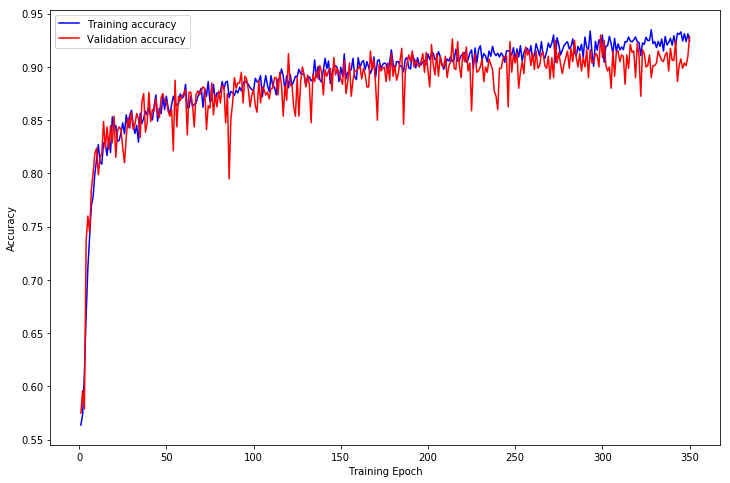

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy')
plt.savefig(output_path + 'training_curve.pdf')

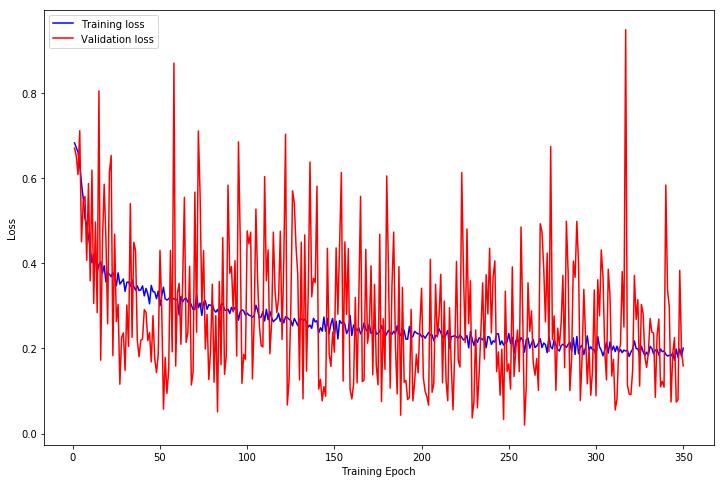

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.savefig(output_path + 'training_loss_curve.pdf')

In [20]:
with open(output_path + 'trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)